Underlying Principle
The principle is simple: we define two distances, one for the content (DC) and one for the style (DS). DC measures how different the content is between two images while DS measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image.


In [72]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from functools import reduce, partial
from toolz import frequencies, partial, compose_left as pipe #seq
from toolz.curried import map as cmap, filter as cfilter

In [73]:
#??torch.cuda
cuda = torch.cuda.is_available()
device = torch.device(cuda and "cuda" or "cpu")
resizer = transforms.Resize(cuda and 512 or 128)

The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

NameError: name 'some' is not defined

In [79]:
img_preprocess = pipe(
    Image.open,
    transforms.Compose(
        [resizer,  # scale imported image
    # desired size of the output image
    # use small size if no gpu
         transforms.ToTensor()]
    ),
    # fake batch dimension required to fit network's input dimensions
    partial(torch.unsqueeze,dim=0),
    lambda img: img.to(device, torch.float)
)

In [80]:
PATH = "../data/"
style_img = img_preprocess(PATH + "picasso.jpg")
content_img = img_preprocess(PATH + "dancing.jpg")

In [81]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [103]:
from functools import wraps
from operator import is_not
def auto_decorate(transform=id, arg_idx=0,keyword=None, klass=None): #runs on arg[0] index, OR on kw OR on type of arg
    def decorator(func):
        @wraps(func)
        def wrapped(*args, **kwargs):
            if (is_not(arg_idx, None)): #bc 0 falls thru 
                indexable = list(args)
                indexable[arg_idx] = transform(args[arg_idx])
                args = tuple(indexable)
            if (keyword): kwargs = { (k, transform(v)) for k,v in kwargs.items()}
            if (klass): None
                #here I need type mappings
                #args = *(tr(arg) if for arg in args if
                
            print(args[0].shape, kwargs)
            return func(*args, **kwargs)
        return wrapped
    
    return decorator

zip

In [83]:
def tensor_to_view(tensor:torch.tensor) -> torch.tensor: return tensor.cpu().clone().squeeze().permute(1,2,0)

torch.Size([512, 512, 3]) {'title': 'Style Image'}


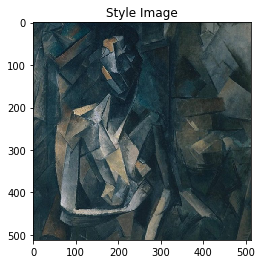

torch.Size([512, 512, 3]) {'title': 'Content Image'}


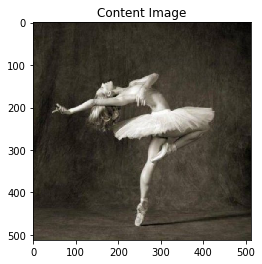

In [84]:
#unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()


#(numpy, tensor)
#(number)
@auto_decorate(, tensor)
def imshow(img, title=""):
    #img = convert(img, to_type=View)
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

## Loss Functions
### Content Loss

X = third image?
C = content image
L = Layer


The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.

In [85]:

#attention: not a true loss function bc it doesn't use autograd
class ContentLoss(nn.Module):
    def __init__(self, target,): #constructor that takes  𝐹_𝐶𝐿  as an input
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        
        #feature maps for some layer 
        self.target = target.detach()

    def forward(self, input):
        #between two SETs of feature maps [[], []]
        self.loss = F.mse_loss(input, self.target)
        return input

ConvLayer output!
In the simplest case, the output value of the layer with input size
    :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
    can be precisely described as:

    .. math::
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


    where :math:`\star` is the valid 2D `cross-correlation`_ operator,
    :math:`N` is a batch size, :math:`C` denotes a number of channels,
    :math:`H` is a height of input planes in pixels, and :math:`W` is
    width in pixels.

In [86]:
def gram(feature_maps):
    #attention, pytorch tensors are (channel, H, W) with images usually
    #but not with conv maps??
    bs, C, H, W = feature_maps.size() #c_depth
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    
    #stacked 3D rectangles...we stack the batches
    features = feature_maps.view(bs*C, H*W)
    # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())
    return G.div(bs * C * H * W) #normalize

In [87]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target_feature = target_feature
        self.target = gram(target_feature).detach()
        #compute my Gram
    def forward(self, input):
        #input is from 3rd image XL
        self.loss = F.mse_loss(gram(input), self.target)
        return input

In [88]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() #features -> just conv and pooling
#eval -> behave the same at train and test

In [89]:
# create a module to normalize input image so we can easily put it in a
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
class Normalization(nn.Module):
    def __init__(self, mean=cnn_normalization_mean, std=cnn_normalization_std):
        super(Normalization, self).__init__()

        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1,1,1)
    def forward(self, img ):
        return (img - self.mean) / self.std   

In [90]:
def split_by(xs, predicate):
    idxs = [idx for idx,x in enumerate(xs) if predicate(x)]
    segments= [*zip([0] + [x+1 for x in idxs], idxs + [idxs[-1] + 1])]
                #don't cut 1st el           #don't cut off last elem
    return [xs[i:j+1] for i,j in segments]

In [91]:
all_layers = list(cnn.children())
#get all the steps

In [92]:
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import ReLU
from operator import itemgetter, attrgetter 

In [93]:
from operator import gt, lt
from toolz import curry

In [94]:
def find_by(xs, predicate, nth=0): return [x for x in xs if predicate(x)][nth]
def find_idx_by(xs, predicate, nth=0): return [idx for idx, x in enumerate(xs) if predicate(x)][nth]

find_by([1,2,3,4], lambda x: x>2), find_idx_by([1,2,3,4], lambda x: x>2) #

(3, 2)

In [95]:
cnn = copy.deepcopy(cnn)
# normalization module
#add_module(name, Loss)
original_layers = list(cnn.children())

In [96]:
##idxs are too brittle if I change the children by injection!!!
inject_spec = [
        #inject .  after:   n_th 
        (StyleLoss, Conv2d, 1),#inject styleloss after the 1st Conv2d layer in network
        (StyleLoss, Conv2d, 2),
        (StyleLoss, Conv2d, 3),
        (StyleLoss, Conv2d, 4),
        (StyleLoss, Conv2d, 5),
        (ContentLoss, Conv2d, 4)
]#.sort(key=itemgetter(2))
inject_spec.sort(key=itemgetter(2))
inject_spec = iter(inject_spec)


In [101]:
from collections import Counter

def inject_model_layers(reference_layers, spec):
    injection = next(spec)
    normalization = Normalization().to(device)
    model = nn.Sequential(normalization)
    
    for layer in reference_layers:
        my_klass, after_layer_type, nth_of_type = injection
        #dict of layer counts
        c = Counter(type(layer) for layer in model.children())
        print(model.children(), c[after_layer_type])
        is_layer = type(layer) == after_layer_type
        is_position = c[after_layer_type] == nth_of_type
        print('is_layer', is_layer, 'pos', is_position, after_layer_type)
        #add our custom layer if we're at the right spot in the iteration 
        print ("CHILD", list(model.children()))
        if (is_layer and is_position):
            target = model(content_img if my_klass == ContentLoss else style_img).detach()
            #print(target, "target", my_klass)
            loss = my_klass(target)
            print(loss, loss.__class__.__name__, "loss")
            model.add_module(loss.__class__.__name__, loss)
            model.add_module(layer.__class__.__name__, layer)
            injection = next(spec)
        
        else: 
            model.add_module(layer.__class__.__name__, layer)

        if not any(injection): #no more injections
            print('end of iteration - break')
            break
    return model

In [102]:
model =inject_model_layers(original_layers, copy.deepcopy(inject_spec))

<generator object Module.children at 0x7f6c1e3393d0> 0
is_layer True pos False <class 'torch.nn.modules.conv.Conv2d'>
CHILD [Normalization()]
<generator object Module.children at 0x7f6c1e3399d0> 1
is_layer False pos True <class 'torch.nn.modules.conv.Conv2d'>
CHILD [Normalization(), Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
<generator object Module.children at 0x7f6c1e3393d0> 1
is_layer True pos True <class 'torch.nn.modules.conv.Conv2d'>
CHILD [Normalization(), Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True)]
StyleLoss() StyleLoss loss
<generator object Module.children at 0x7f6c1e3394d0> 1
is_layer False pos False <class 'torch.nn.modules.conv.Conv2d'>
CHILD [Normalization(), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), StyleLoss()]
<generator object Module.children at 0x7f6c1e3399d0> 1
is_layer False pos False <class 'torch.nn.modules.conv.Conv2d'>
CHILD [Normalization(), Conv2d(64,

In [100]:
list(model.children())

[Normalization(),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 StyleLoss(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [32]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [36]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

torch.Size([512, 512, 3]) {'title': 'Input Image'}


<Figure size 432x288 with 0 Axes>

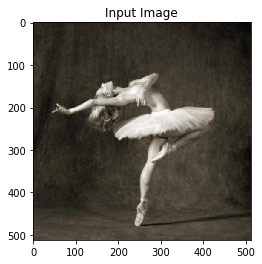

In [37]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

NameError: name 'style_losses' is not defined

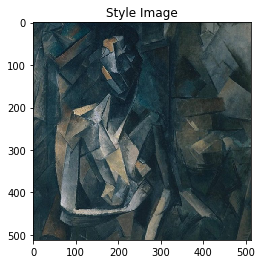

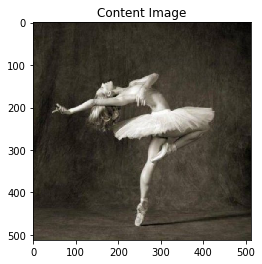

In [61]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Style_loss is a tensor ....that's why it can be .backward() and also optim.step()

In [71]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            print(style_score, type(style_score), "style_score")

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
tensor(1.4893e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4894e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4886e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4839e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4880e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4849e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4850e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4856e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4852e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4848e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4843e

tensor(1.4696e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4700e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4695e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4681e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4669e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4661e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4662e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4671e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4678e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4680e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4685e-07, device='cuda:0', grad_fn=<AddBa

tensor(1.4576e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4570e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4576e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4584e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4562e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4555e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4558e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4555e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4553e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4530e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4548e-07, device='cuda:0', grad_fn=<AddBa

tensor(1.4354e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4342e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4334e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4334e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4338e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4352e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4354e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4359e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4398e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4368e-07, device='cuda:0', grad_fn=<AddBackward0>) <class 'torch.Tensor'> style_score
tensor(1.4324e-07, device='cuda:0', grad_fn=<AddBa

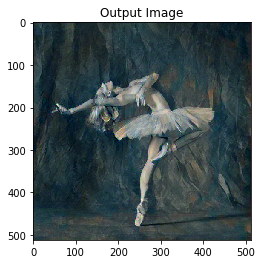

In [70]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [45]:
head = itemg


In [48]:
a = [1,2,3,4,5]

TypeError: type object argument after * must be an iterable, not int

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [56]:
itemgetter(*[1,4,3])(["a","b","c","d", "e"])
itemgetter(2)("a","b","c","d", "e")

TypeError: itemgetter expected 1 arguments, got 5

In [ ]:
from collections import abc
def nested_dict_iter(nested):
    for key, value in nested.items():
        if isinstance(value, abc.Mapping):
            yield from nested_dict_iter(value)
        else:
            yield key, value